In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

backend = set_backend("numpy", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image
import cortex
import nibabel as nib
import os
opj = os.path.join

from matplotlib.colors import Normalize
def Vertex2D_fix(data1, data2, subject, cmap, vmin, vmax, vmin2, vmax2, roi_borders=None):
    #this provides a nice workaround for pycortex opacity issues, at the cost of interactivity    
    # Get curvature
    curv = cortex.db.get_surfinfo(subject)
    # Adjust curvature contrast / color
    curv.data = curv.data * .75 +0.1
    curv = cortex.Vertex(curv.data, subject, vmin=-1,vmax=1,cmap='gray')
    norm2 = Normalize(vmin2, vmax2)   
    vx = cortex.Vertex(data1, subject, cmap=cmap, vmin=vmin, vmax=vmax)
    # Map to RGB
    vx_rgb = np.vstack([vx.raw.red.data, vx.raw.green.data, vx.raw.blue.data])
    curv_rgb = np.vstack([curv.raw.red.data, curv.raw.green.data, curv.raw.blue.data])
    # Alpha mask
    alpha = np.clip(norm2(data2), 0, 1)
    display_data = (curv_rgb * (1-alpha)) + vx_rgb * alpha
    display_data /= 255
    if roi_borders is not None:
        display_data[:,roi_borders.astype('bool')] = 0
    
    # Create vertex RGB object out of R, G, B channels
    return cortex.VertexRGB(*display_data, subject) 

from AOTanalysis.voxelmotion.filter_info import FilterInfo

backend = set_backend("numpy", on_error="warn")

In [3]:
sub = 3
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside2/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Yzscore_True_Xstd_True_testinside.joblib"
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1_2_3.joblib"
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1.joblib"
model = joblib.load(model_path)
cx_sub = f'sub-{sub:03d}'
deriv_dir = '/tank/shared/2024/visual/AOT/derivatives/'
param_path_dir = opj(deriv_dir, "prf", cx_sub)
fs_dir = opj(deriv_dir, "freesurfer")

/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("n_features, n_voxels) =", primal_coef.shape)
primal_coef = primal_coef.numpy()
max_index = np.argmax(primal_coef, axis=0)
print("max_index.shape =", max_index.shape)

n_features, n_voxels) = torch.Size([11845, 352914])
max_index.shape = (352914,)


In [5]:
# Load the R2 scores for masking
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/R2_score_single_sub{sub}_motion_train_1_2_3_test_4.nii.gz"
R2 = nib.load(R2_file)
R2_data = R2.get_fdata()
print("R2_data shape:", R2_data.shape)
R2_data = np.transpose(R2_data, (2, 1, 0))
print("Transposed R2_data shape:", R2_data.shape)

R2_data shape: (84, 95, 106)
Transposed R2_data shape: (106, 95, 84)


In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint
import moten  # assuming moten is installed

class FilterInfoV2:
    def __init__(self, vhsize=(1080, 1920), fps=24,
                 spatial_frequencies=[0, 2, 4, 8, 16, 32], **kwargs):
        self.vhsize = vhsize
        self.aspect_ratio = vhsize[1] / vhsize[0]
        self.fps = fps
        self.spatial_frequencies = spatial_frequencies
        self.pyramid = moten.get_default_pyramid(
            vhsize=self.vhsize, fps=self.fps,
            spatial_frequencies=self.spatial_frequencies
        )
        # screen geometry
        self.screen_distance = kwargs.get("screen_distance", 196)
        self.screen_height = kwargs.get("screen_height", 39.3)
        self.screen_width = self.aspect_ratio * self.screen_height
        self.screen_height_dov = 2 * np.degrees(
            np.arctan(self.screen_height / (2 * self.screen_distance))
        )
        self.screen_width_dov = 2 * np.degrees(
            np.arctan(self.screen_width / (2 * self.screen_distance))
        )

        # build filter dataframe
        params = self.pyramid.parameters
        # center in dov
        x_dov, y_dov = self._screen2dov(params['centerh'], params['centerv'])
        ecc, pol = self._cart2pol(x_dov, y_dov)

        data = {            
            'x': x_dov,
            'y': y_dov,
            'ecc': ecc,
            'pol': pol,
            'SF': params['spatial_freq'],#*1/self.screen_height_dov,  # cycle/image * 1/(deg/image) = cycle/degree 
            'size': params['spatial_env']*self.screen_height_dov,   # s.d (image) * 
            'TF': params['temporal_freq'],
            'dir': params['direction'],
        }
        # velocity
        vel = data['TF'] / data['SF']
        vel[(data['SF'] == 0) | (data['TF'] == 0)] = 0
        data['vel'] = vel

        self.filter_df = pd.DataFrame(data)
        self.params_list = list(self.filter_df.columns)
        self.n_filters = len(self.filter_df)

        # cache numpy arrays for speed
        self._arrays = {p: self.filter_df[p].to_numpy() for p in self.params_list}

    def p_selectivity(self, w, param):
        """ compute the selectivity to a features
        selectivity_index = (Max Weight - min Weight) / (sum Weights)
        """
        if w.ndim == 1:
            w = w[:, None]
        if w.shape[0] != self.n_filters:
            raise ValueError("Weights must have shape (n_filters, N)")        
        unique = np.unique(self.filter_df[param])
        collapsed_ws = []
        for u in unique:
            idx = np.where(self.filter_df[param]==u)
            collapsed_ws.append(
                np.abs(w[idx,:].sum(axis=1))
            )
        collapsed_ws = np.vstack(collapsed_ws) # n unique x n weights
        sensitivity = (np.max(collapsed_ws, axis=0) - np.min(collapsed_ws, axis=0)) / np.sum(collapsed_ws, axis=0)
        return sensitivity

    def filter_weighted_mean(self, weights, params=None):
        """
        Compute weighted means for a set of weight vectors.
        weights: array of shape (n_filters, N)
        Returns: DataFrame of shape (N, len(params))
        """
        w = np.asarray(weights)
        if w.ndim == 1:
            w = w[:, None]
        if w.shape[0] != self.n_filters:
            raise ValueError("Weights must have shape (n_filters, N)")

        if params is None:
            params = self.params_list
        # sum of weights per column
        wsum = w.sum(axis=0)
        out = {}
        for p in params: 
            if p in ['x', 'y', 'ecc', 'SF', 'size', 'TF', 'vel']:
                # straightforward means
                arr = self._arrays[p][:, None]  # shape (F,1)
                mean_vals = (w * arr).sum(axis=0) / wsum
                out[p] = mean_vals
            elif p in ['pol']:
                # polarity: from x,y means
                mx = ((w * self._arrays['x'][:, None]).sum(axis=0) / wsum)
                my = ((w * self._arrays['y'][:, None]).sum(axis=0) / wsum)
                _, pol_mean = self._cart2pol(mx, my)
                out['pol'] = pol_mean
            elif p in ['dir']:
                # direction: circular mean
                theta = np.deg2rad(self._arrays['dir'])[:, None]
                sin_sum = (w * np.sin(theta)).sum(axis=0)
                cos_sum = (w * np.cos(theta)).sum(axis=0)
                dir_mean = (np.rad2deg(np.arctan2(sin_sum, cos_sum)) % 360)
                out['dir'] = dir_mean
        # assemble DataFrame
        return pd.DataFrame(out)

    def filter_max(self, weights, params=None):
        """
        For each weight vector, return parameters at index of max weight.
        weights: array (n_filters, N)
        Returns: DataFrame (N, len(params))
        """
        w = np.asarray(weights)
        if w.ndim == 1:
            w = w[:, None]
        if w.shape[0] != self.n_filters:
            raise ValueError("Weights must have shape (n_filters, N)")

        if params is None:
            params = self.params_list
        # index of max per column
        idx = w.argmax(axis=0)
        out = {}
        for p in params:
            arr = self._arrays[p]
            out[p] = arr[idx]
        return pd.DataFrame(out)


    def _screen2dov(self, xscr, yscr):
        """
        xscr from pymoten is in range [0, aspect ratio] and yscr in [0, 1].
        Convert these to degrees of visual angle (DoV) coordinates.
        """
        # Centre the screen coordinates 0 = middle of the screen
        x_c = xscr - self.aspect_ratio / 2
        y_c = yscr - 0.5
        
        # Now range is [-aspect_ratio/2, aspect_ratio/2] for x_c and [-0.5, 0.5] for y_c
        # Convert to DoV coordinates by 
        x_off = x_c * self.screen_width_dov
        y_off = y_c * self.screen_height_dov
        
        return (np.degrees(np.arctan2(x_off, self.screen_distance)),
                np.degrees(np.arctan2(y_off, self.screen_distance)))

    def _dov2screen(self, dov_x, dov_y):
        # 1. Convert DoV from degrees to radians
        rad_x = np.radians(dov_x)
        rad_y = np.radians(dov_y)

        # 2. Reverse arctan2 to find x_off and y_off
        x_off = np.tan(rad_x) * self.screen_distance
        y_off = np.tan(rad_y) * self.screen_distance

        # 3. Reverse x_off and y_off calculations to find x_c and y_c
        x_c = x_off / self.screen_width
        y_c = y_off / self.screen_height

        # 4. Reverse x_c and y_c calculations to find xscr and yscr
        xscr = x_c + self.aspect_ratio / 2
        yscr = y_c + 0.5
        
        return xscr, yscr

    def _cart2pol(self, x, y):
        r = np.hypot(x, y)
        theta = np.arctan2(y, x)
        return r, theta
    
    def _pol2cart(self, r, theta):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        return x, y    

    def test(self):
        pprint(self.pyramid)
        pprint(self.pyramid.parameters)
f3 = FilterInfoV2()
def plot_centered_imshow(ax, mat, x, y, size, **kwargs):
    """
    Plot an image (matrix) centered at (x, y) with the given size (width, height).

    Parameters:
    ax   -- matplotlib axis to plot on
    mat  -- 2D numpy array (n x m) representing the image
    x, y -- coordinates for the center of the image
    size -- tuple (width, height) specifying the size of the image
    """
    width, height = size
    extent = [x - width / 2, x + width / 2, y - height / 2, y + height / 2]
    ax.imshow(mat, extent=extent, origin='lower', aspect='auto', **kwargs)

/tmp/ipykernel_369860/202355642.py:45: RuntimeWarning: divide by zero encountered in divide
  vel = data['TF'] / data['SF']
/tmp/ipykernel_369860/202355642.py:45: RuntimeWarning: invalid value encountered in divide
  vel = data['TF'] / data['SF']


In [142]:
f3.pyramid.parameters['centerv'].max()


np.float64(0.9593750000000001)

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
def plot_centered_imshow(ax, mat, x, y, size, **kwargs):
    """
    Plot an image (matrix) centered at (x, y) with the given size (width, height).

    Parameters:
    ax   -- matplotlib axis to plot on
    mat  -- 2D numpy array (n x m) representing the image
    x, y -- coordinates for the center of the image
    size -- tuple (width, height) specifying the size of the image
    """
    width, height = size
    extent = [x - width / 2, x + width / 2, y - height / 2, y + height / 2]
    ax.imshow(mat, extent=extent, origin='lower', aspect='auto', **kwargs)

def plot_tf_sf_maps(filt_info, weights, vmin=None, vmax=None, cmap='viridis', ):
    """
    Plot TF x SF maps as small images located at each (x, y) filter position.

    Parameters:
        filt_info: an instance of FilterInfoV2
        weights: (n_filters,) array of weights
        vmin, vmax: color scale limits
        cmap: colormap for the images
        show_axes: whether to show axis labels and ticks
    """
    weights = np.asarray(weights)
    if weights.ndim == 1:
        weights = weights[:, None]

    df = filt_info.filter_df
    x_vals = df['x'].to_numpy()
    y_vals = df['y'].to_numpy()
    sf_vals = df['SF'].to_numpy()
    tf_vals = df['TF'].to_numpy()

    unique_sf = np.sort(df['SF'].unique())
    unique_tf = np.sort(df['TF'].unique())
    n_sf = len(unique_sf)
    n_tf = len(unique_tf)

    xy = np.stack([x_vals, y_vals], axis=1)
    xy_unique, xy_idx = np.unique(xy, axis=0, return_inverse=True)
    n_locs = len(xy_unique)

    all_mats = []
    for loc in range(n_locs):
        loc_mask = (xy_idx == loc)
        sf_sub = sf_vals[loc_mask]
        tf_sub = tf_vals[loc_mask]

        mat = np.zeros((n_tf, n_sf))
        overall_weights = np.zeros(n_locs)
        for i, sf in enumerate(unique_sf):
            for j, tf in enumerate(unique_tf):
                match = (sf_sub == sf) & (tf_sub == tf)
                if np.any(match):
                    mat[j, i] = np.mean(weights[loc_mask][match])
                    overall_weights[loc] += np.sum(weights[loc_mask][match])
        all_mats.append((xy_unique[loc], overall_weights[loc], mat))

    # PLOTTING
    # round x and y for limits
    xmin, xmax = np.floor(xy_unique[:, 0].min())-0.5, np.ceil(xy_unique[:, 0].max())+0.5
    ymin, ymax = np.floor(xy_unique[:, 1].min())-0.5, np.ceil(xy_unique[:, 1].max())+0.5    
    # Fig + ax, with correct aspect ratio
    fig, ax = plt.subplots(figsize=(8*filt_info.aspect_ratio, 8))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # top n percentile of s
    overall_weight_pc = np.percentile(
        [s for _, s, _ in all_mats], 98
    )
    print("Overall weight 99th percentile:", overall_weight_pc)
    # bloop
    for (x, y),s, mat in all_mats:
        if s < overall_weight_pc:
            continue
        plot_centered_imshow(
            ax, mat, x, y,
            size=(0.1*n_sf, 0.1*n_tf),
            cmap=cmap, vmin=vmin, vmax=vmax
        )

    plt.title('TF x SF Weight Maps Plotted at (x, y) Locations')
    # plt.colorbar(sm, ax=ax, label='Collapsed Weights')
    plt.show()


In [45]:
np.argmax(np.max(np.abs(primal_coef), axis=0))

np.int64(60003)

Overall weight 99th percentile: 2.608941822024316e-09


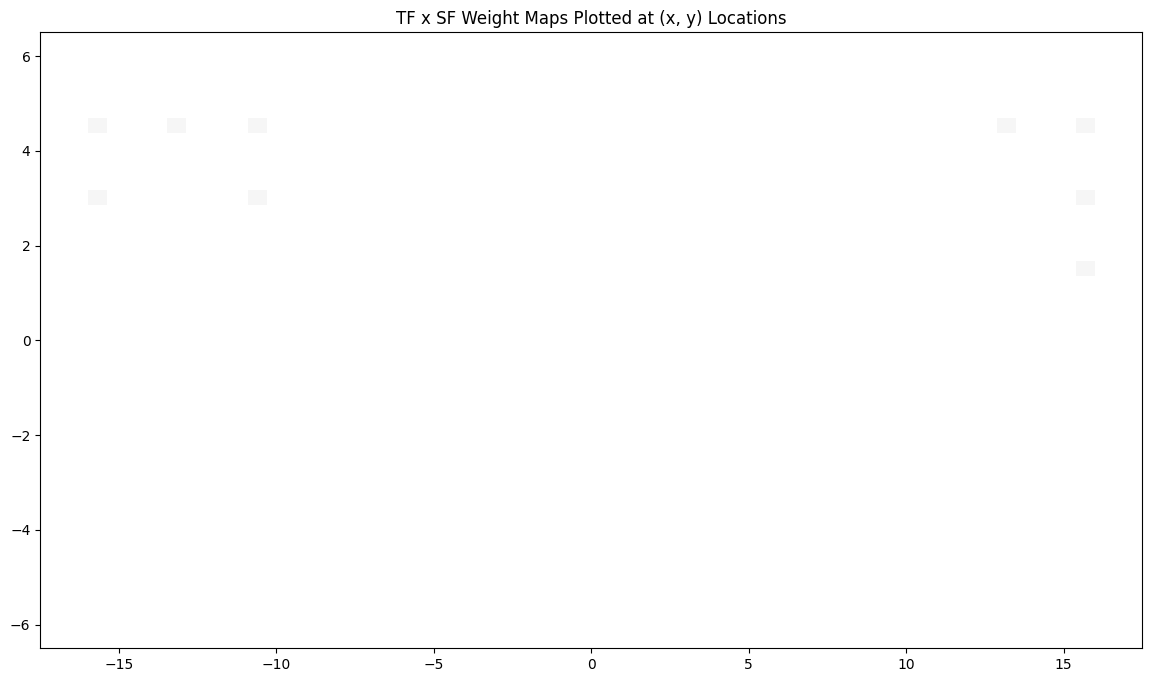

In [118]:
plot_tf_sf_maps(f3, weights=primal_coef[:,671], vmin=-0.01, vmax=0.01, cmap='RdBu')

In [15]:
primal_coef.shape

(11845, 352914)

In [102]:
# wm = f3.filter_weighted_mean(primal_coef, ) #params=['pol'])
dir_s = f3.p_selectivity(
    primal_coef, param='x'
)

In [120]:
import numpy as np
from sklearn.decomposition import PCA

# Suppose data is a numpy array of shape (n_instances, n_features)
# If yours is (n_features, n_instances), just transpose it:
# data = data.T

# Initialize PCA: choose number of components (e.g. 2) or fraction of variance
pca = PCA(n_components=2)    
# Fit & transform the data
X_reduced = pca.fit_transform(primal_coef.T)  # Transpose to shape (n_instances, n_features)

print("Explained variance ratios:", pca.explained_variance_ratio_)
print("Projected shape:", X_reduced.shape)

Explained variance ratios: [0.17036949 0.14859624]
Projected shape: (352914, 2)


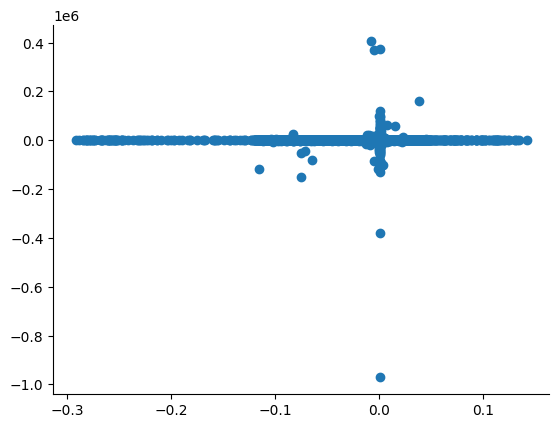

In [ ]:
from dpu_mini.plot_functions import *
dag_scatter(
    X_reduced[:, 1], 
    wm['x'],
    
)

In [135]:
np.max(wm['x'])

np.float64(404406.45309468656)

In [134]:
wm = f3.filter_weighted_mean(primal_coef,)

(array([7.2000e+01, 5.5100e+02, 1.6880e+03, 3.4960e+03, 6.2310e+03,
        1.0082e+04, 1.7588e+04, 2.7966e+04, 3.7580e+04, 4.3231e+04,
        4.2912e+04, 3.8931e+04, 3.2553e+04, 2.5400e+04, 1.9227e+04,
        1.3894e+04, 9.5730e+03, 6.8980e+03, 4.6830e+03, 3.2370e+03,
        2.2450e+03, 1.5390e+03, 1.0530e+03, 7.0800e+02, 4.7100e+02,
        3.1300e+02, 2.1400e+02, 1.8200e+02, 1.0400e+02, 1.0400e+02,
        5.4000e+01, 4.4000e+01, 2.4000e+01, 2.5000e+01, 1.1000e+01,
        5.0000e+00, 7.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.02557739, 0.03233297, 0.03908855, 0.04584414, 0.05259972,
        0.0593553 , 0.06611089, 0.07286647, 0.07962205, 0.08637764,
        0.09313321, 0.09988879, 0.10664438, 0.11339996, 0.12015554,
        0.12691113, 0.13366671, 0.1404223 , 0.14717788, 0.15393347,
        0.16068904, 0.16744463, 0.17420021, 0.

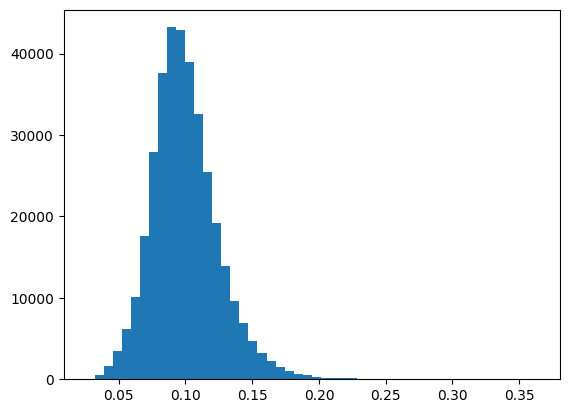

In [103]:
plt.hist(dir_s, bins=50)

In [106]:
np.where(dir_s>0.3)

(array([120238, 209397, 272846, 278236, 278327]),)

In [109]:
dir_sel = f3.p_selectivity(
    primal_coef, param='dir'
)

In [116]:
np.where(dir_sel>0.7)

(array([   671,   1503,   1539,   2006,   2579,   2582,   2987,   4166,
          6638,   7013,   7529,   9141,   9299,   9580,   9947,  10163,
         10428,  11654,  13850,  16498,  17569,  23310,  23962,  24919,
         25219,  26393,  28712,  28816,  29168,  30055,  31493,  33135,
         33184,  34279,  35172,  35400,  36658,  38430,  38991,  43471,
         43619,  45524,  46078,  46552,  46679,  47238,  47536,  50284,
         50570,  53065,  55559,  56004,  56182,  56616,  57864,  58873,
         59139,  60312,  60599,  60699,  62393,  63096,  64319,  64360,
         65010,  65282,  65497,  65624,  65773,  65882,  66451,  66606,
         68014,  68815,  69626,  70927,  72589,  72956,  73560,  73765,
         74278,  74495,  75539,  76115,  78320,  78701,  78800,  79539,
         80161,  80405,  81981,  82483,  83878,  84171,  85126,  86523,
         86742,  87188,  89482,  89638,  89924,  89999,  90510,  91157,
         91395,  91637,  92454,  92800,  92859,  92922,  93995, 

(array([1.28810e+04, 7.36700e+04, 1.26362e+05, 7.85760e+04, 3.61170e+04,
        1.63860e+04, 6.59900e+03, 1.92600e+03, 3.71000e+02, 2.60000e+01]),
 array([0.01936523, 0.10655743, 0.19374964, 0.28094181, 0.36813402,
        0.45532623, 0.54251844, 0.62971067, 0.71690285, 0.80409503,
        0.89128727]),
 <BarContainer object of 10 artists>)

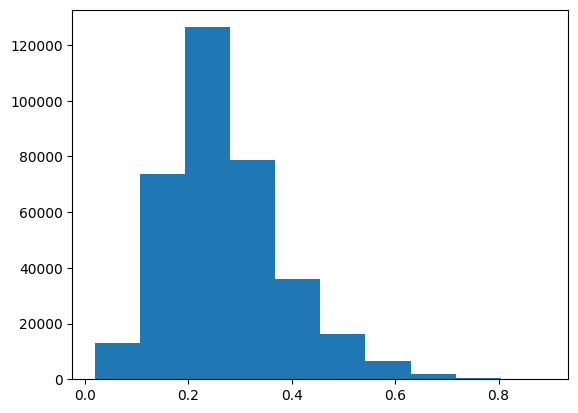

In [110]:
plt.hist(dir_sel, )

In [ ]:
dag_scatter(
    f3.pyramid.parameters['spatial_env'],
    f3.pyramid.parameters['spatial_freq'],
)

# plt.show()

In [ ]:
((f3.pyramid.parameters['spatial_env']==0.3) & (f3.pyramid.parameters['spatial_freq']==8.0)).sum()

In [ ]:
np.unique(f3.pyramid.parameters['spatial_freq'])
np.unique(f3.pyramid.parameters['spatial_env'])

In [125]:
# with open('wm.pkl', 'wb') as f:
#     pickle.dump(wm, f)
with open('wm.pkl', 'rb') as f:
    wm = pickle.load(f)

In [8]:
wm

,x,y,ecc,pol,SF,size,TF,dir,vel
0,3.239301,6.376469,7.790396,1.100762,330.029703,0.283647,2.346221,92.652904,0.007903
1,-0.618531,-2.049872,8.281636,-1.863850,300.517509,0.291680,2.226720,29.083379,0.007893
2,52.230245,-6.748716,18.076176,-0.128499,380.123842,-0.121982,0.987638,40.789216,-0.011655
3,-59.860482,52.976121,69.731574,2.417131,267.455861,-0.100555,3.663207,272.228142,0.000106
4,0.340997,10.583196,18.100870,1.538587,184.736442,0.273093,1.595361,213.553032,0.000117
...,...,...,...,...,...,...,...,...,...
352909,7.771524,18.560300,10.692578,1.174259,315.134023,0.295812,3.321835,346.097982,0.011038
352910,0.901114,2.188089,15.521511,1.180136,319.939756,0.269297,2.362066,257.143296,0.008194
352911,29.159969,-2.480832,14.683865,-0.084872,348.201013,0.156159,5.217506,155.788573,0.015173
352912,1.680794,1.195631,9.978224,0.618302,291.222874,0.285857,2.078635,83.985315,0.007152


volume shape: (84, 95, 106)
Caching mapper...
Caching mapper...


/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Unable to init server: Could not connect: Connection refused
Background RRGGBBAA: ffffff00
Area 0:0:1975.19:1024 exported to 1975 x 1024 pixels (96 dpi)
Unable to init server: Could not connect: Connection refused
Background RRGGBBAA: ffffff00
Area 0:0:1975.19:1024 exported to 1975 x 1024 pixels (96 dpi)


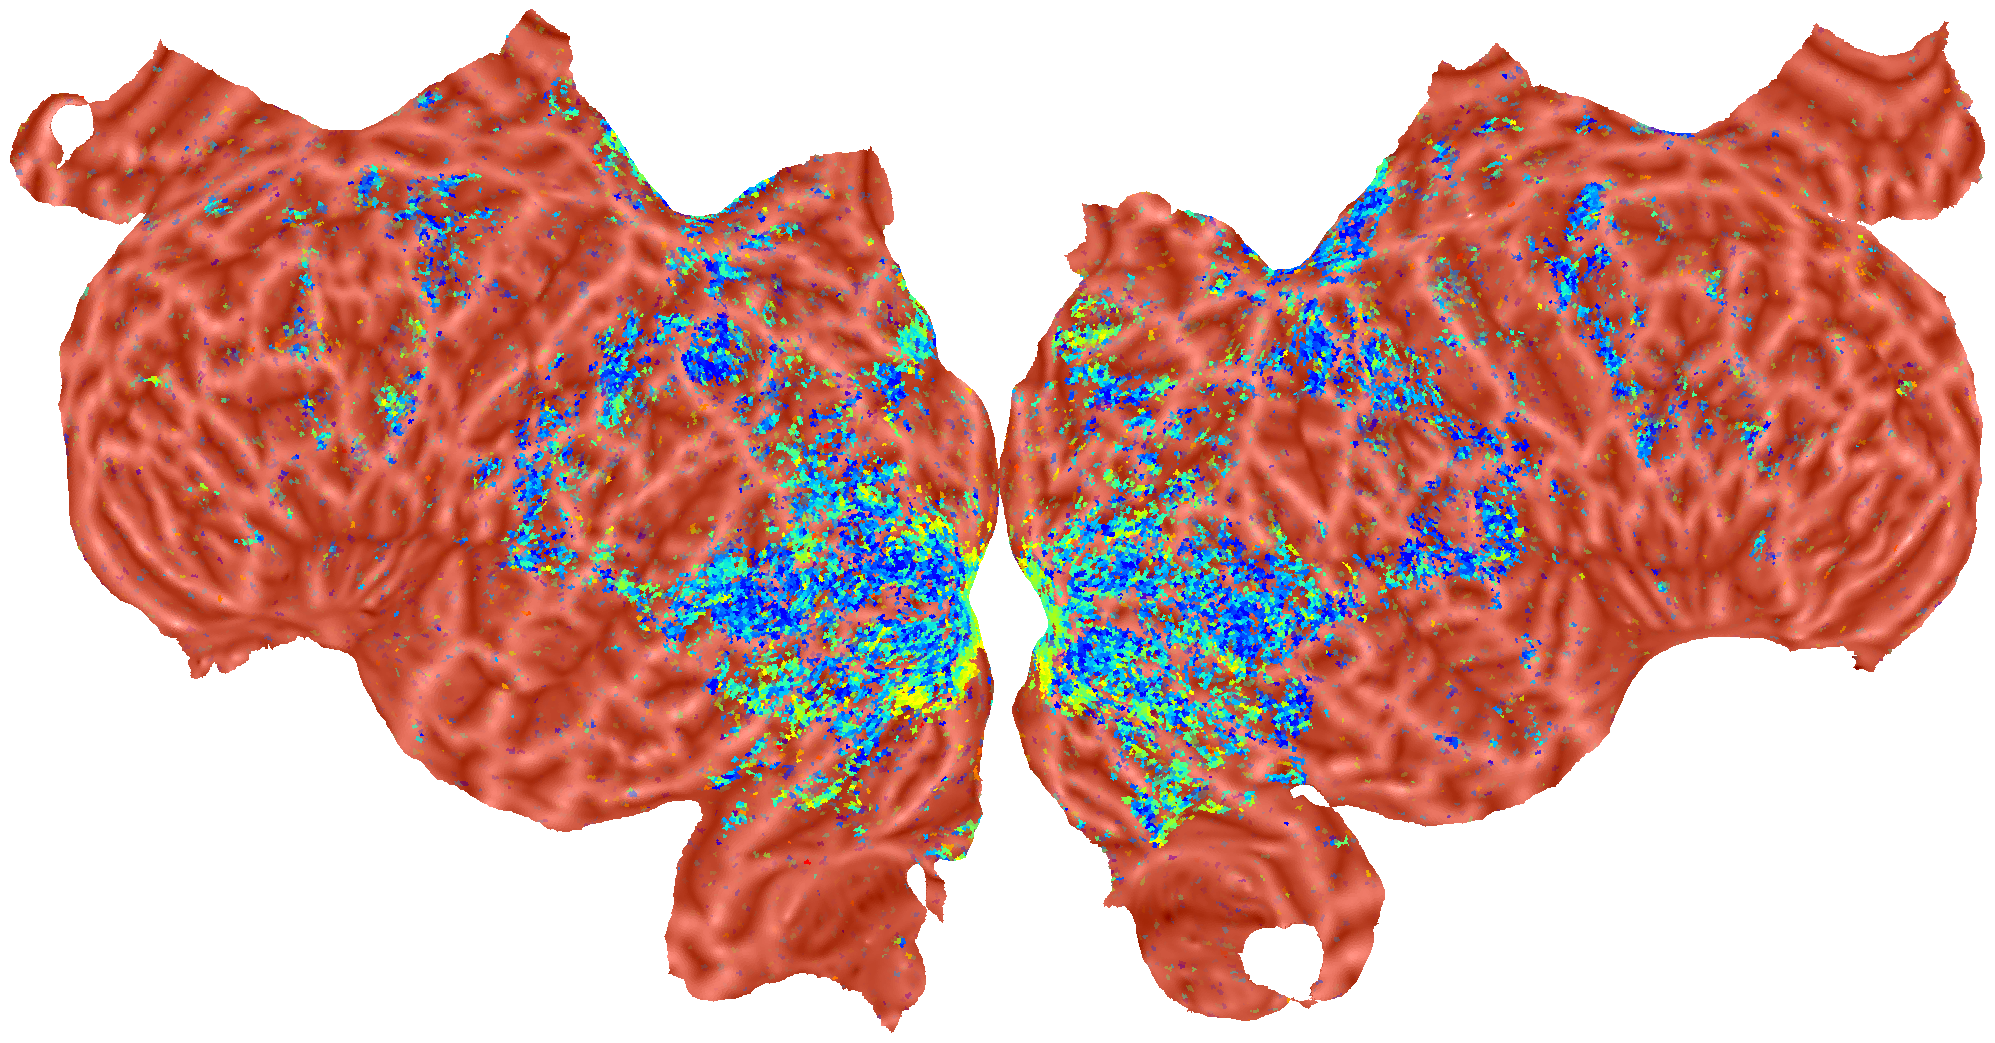

In [ ]:
# Reshape the eccentricities into a volume
p = 'pol'
vol = reshape_from_flatten_masked_to_wholebrain(
    dir_s, #
    # wm[p].to_numpy(), 
    sub=sub)
cx_sub = f'sub-{sub:03d}'
print("volume shape:", vol.shape)

# Transpose the volume to match the expected shape (106, 95, 84)
vol = np.transpose(vol, (2, 1, 0))
cx_vol = cortex.Volume(vol, cx_sub, xfmname='AOT1pt7mm',vmin=0.1, vmax=20, cmap="magma")

mapper = cortex.get_mapper(cx_sub, "AOT1pt7mm", type="nearest", recache=True)
p_map = mapper(cx_vol)

volume_R2 = cortex.Volume(R2_data, cx_sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(cx_sub, "AOT1pt7mm", type="nearest", recache=True)
R2_map = mapper_R2(volume_R2)
cmap_kwargs = {
    "cmap": "jet",
    "vmin": 0,
    "vmax": 0.8,
}
# Create merged map with R2 as opacity
merged_map = Vertex2D_fix(
    p_map.data,
    R2_map.data,
    cx_sub,

    vmin2=0,
    vmax2=0.01,  # R2 threshold for opacity
    **cmap_kwargs
)
# from dag_prf_utils.plot_functions import *


# Set colormap for surface map
# p_map.cmap = "hsv"

# Display the merged map
_ = cortex.quickshow(
    merged_map,
    with_curvature=False,
    with_colorbar=False,
    with_labels=True,
    with_sulci=True,
    with_legend=False,
    # cmap="hsv",
    colorbar_label=p,
)

# Add figure (a) to plt.gcf()



from dag_prf_utils. import *
dag_plot

(array([1.28810e+04, 7.36700e+04, 1.26362e+05, 7.85760e+04, 3.61170e+04,
        1.63860e+04, 6.59900e+03, 1.92600e+03, 3.71000e+02, 2.60000e+01]),
 array([0.01936523, 0.10655743, 0.19374964, 0.28094181, 0.36813402,
        0.45532623, 0.54251844, 0.62971067, 0.71690285, 0.80409503,
        0.89128727]),
 <BarContainer object of 10 artists>)

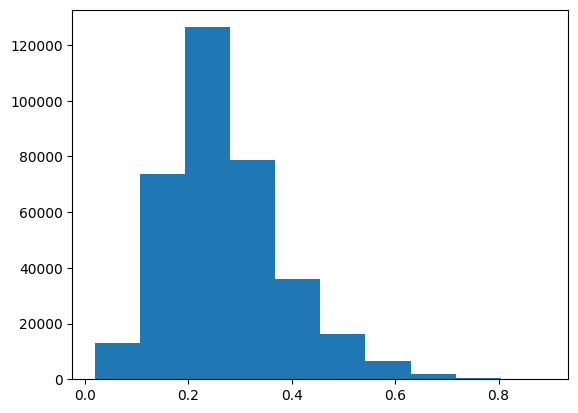

In [19]:
plt.hist(dir_s)

In [11]:
from dpu_mini.mesh_maker import GenMeshMaker

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
SUBJECTS_DIR not found in os.environ
Adding empty string...


In [12]:
gm = GenMeshMaker(
    sub=cx_sub, 
    # fs_dir=fs_dir
    fs_dir=opj(deriv_dir, 'freesurfer_AOT')
)

Using fs dir = /tank/shared/2024/visual/AOT/derivatives/freesurfer_AOT
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...


In [75]:
gm.total_n_vx

308926

In [ ]:
from dpu_mini.fs_tools import dag_load_roi
c_bool = dag_load_roi(cx_sub, 'V1_exvivo.thresh', fs_dir=gm.fs_dir)
submesh_bool = dag_mesh_morph(
    mesh_info=gm.mesh_info['inflated']['lh'], 
    vx_bool=, 
    morph=morph)
gm.make_flat_map(
    centre_bool=,
    morph=-1, 
    method='igl',
    hemi_project='sphere'
)
# gm.flat_mpl(roi_list='V2_')

Missing 2 vx
If you want to be more inclusive try again with morph>0


RuntimeError: Failed to compute harmonic map

In [ ]:
# Create cortex volumes for eccentricities and R2
volume = cortex.Volume(eccentricities_volume, sub, "AOT1pt7mm", recache=True)
mapper = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map = mapper(volume)

volume_R2 = cortex.Volume(R2_data, sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map_R2 = mapper_R2(volume_R2)

In [ ]:
filter_info.pyramid.show_filter(3)
plt.show()

In [ ]:
filter_info.pyramid.show_filter(100)
plt.show()

In [ ]:
# Load some 
import os 
opj = os.path.join
subject = "sub-003"
cx_sub = f"aot-{subject}"

deriv_dir = '/tank/shared/2024/visual/AOT/derivatives/'
param_path_dir = opj(deriv_dir, "prf", subject)
fs_dir = opj(deriv_dir, "freesurfer")
os.environ["SUBJECTS_DIR"] = str(fs_dir)
# if not os.path.exists(os.path.join(cortex.database.default_filestore, cx_sub)):
#     cortex.freesurfer.import_subj(freesurfer_subject=subject,
#                                     pycortex_subject=cx_sub,
#                                     freesurfer_subject_dir=fs_dir)

In [ ]:
prf_list = os.listdir(opj(param_path_dir, 'prf_fits', 'params'))
from dpu_mini.utils import *
import nibabel as nib
import cortex
bold_ref = dag_find_file_in_folder(
    ['r2', 'cv', 'gauss'], 
    opj(param_path_dir, 'prf_fits', 'params'),
)
def get_prf_par(filt):
    nii = dag_find_file_in_folder(
        filt, 
        opj(param_path_dir, 'prf_fits', 'params'),
    )
    return nib.load(nii).get_fdata()
vol = get_prf_par(['r2','gauss', 'cv'])
rsq_data = cortex.Volume(vol.transpose(2,1,0), subject='sub-003', 
                         xfmname='epi_1.7mm',
                           vmin=0.1, vmax=0.7, cmap="magma")
sub='sub-003'
volume_R2 = cortex.Volume(vol.transpose(2,1,0), sub, "epi_1.7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "epi_1.7mm", type="nearest", recache=True)
# native_surface_map_R2 = mapper_R2(volume_R2)
native_surface_map_R2 = mapper_R2(volume_R2)
# gm.flat_mpl(
#     data=native_surface_map_R2.data,
# )
cortex.quickshow(native_surface_map_R2)

In [ ]:
sub='sub-003'
volume_R2 = cortex.Volume(vol.transpose(2,1,0), sub, "epi_1.7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "epi_1.7mm", type="nearest", recache=True)
# native_surface_map_R2 = mapper_R2(volume_R2)
native_surface_map_R2 = mapper_R2(volume_R2)
# gm.flat_mpl(
#     data=native_surface_map_R2.data,
# )
cortex.quickshow(native_surface_map_R2)

In [ ]:
gm.total_n_vx

In [ ]:
# from cortex import quickshow as quickshow
quickshow(rsq_data,)

In [ ]:
cortex.db.get_surf('sub-003', 'flat')

In [ ]:
cortex.vertex_to_voxel('sub-003')

In [ ]:
from dpu_mini.mesh_maker import GenMeshMaker
from dpu_mini.fs_tools import *

gm = GenMeshMaker(subject, fs_dir)
centre_bool = dag_load_roi(subject, 'V1', fs_dir=fs_dir)

gm.make_flat_map(centre_bool=centre_bool,morph=20, method='igl')
gm.flat_mpl(roi_list=['V1', 'V2'])

In [ ]:
from dag_prf_utils.pycortex import *

In [ ]:
import numpy as np
import cortex
custom_affine = np.identity(4)
# custom_affine[1,3] -= 8
# transform = cortex.xfm.Transform(custom_affine, bold_ref)
xfmname = "aot_prep"
# transform.save(cx_sub, xfmname, 'magnet')

In [ ]:
rsq_data = cortex.Volume(gauss_rsq_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0.1, vmax=0.7, cmap="magma")
polar_vcx = cortex.Volume(gauss_polar_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-np.pi, vmax=np.pi, cmap="Retinotopy_HSV_2x_alpha")
ecc_data = cortex.Volume(gauss_ecc_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=8, cmap="magma")
x_data = cortex.Volume(gauss_x_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-4, vmax=4, cmap="coolwarm")
y_data = cortex.Volume(gauss_y_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-4, vmax=4, cmap="coolwarm")
prf_ampl_data = cortex.Volume(gauss_prf_ampl_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=10, cmap="magma")
prf_size_data = cortex.Volume(gauss_prf_size_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=6, cmap="magma")

cortex.webgl.show({"rsq": rsq_data, "polar": polar_vcx, "ecc": ecc_data, "x": x_data, "y": y_data, "prf_ampl": prf_ampl_data, "prf_size": prf_size_data,})

In [ ]:
path_bold_ref = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")
param_path_norm_r2 = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")
param_path_norm_ecc = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_ecc.nii.gz")
param_path_norm_polar = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_polar.nii.gz")
param_path_norm_x = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz")
param_path_norm_y = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz")
param_path_norm_prf_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_ampl.nii.gz")
param_path_norm_neur_bsl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_neur_bsl.nii.gz")
param_path_norm_surr_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_ampl.nii.gz")
param_path_norm_surr_bsl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_bsl.nii.gz")
param_path_norm_prf_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz")
param_path_norm_surr_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_size.nii.gz")

param_path_gauss_r2 = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")

param_path_gauss_ecc = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_ecc.nii.gz")
param_path_gauss_polar = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_polar.nii.gz")

param_path_gauss_x = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz")
param_path_gauss_y = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz")
param_path_gauss_prf_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_prf_ampl.nii.gz")
param_path_gauss_prf_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz")

In [ ]:
import nibabel as nib
bold_ref = nib.load(path_bold_ref)

gauss_rsq_data = nib.load(param_path_gauss_r2).get_fdata()
gauss_ecc_data = nib.load(param_path_gauss_ecc).get_fdata()

def load_gauss_param_image(param_path, rsq_data=gauss_rsq_data, rsq_threshold=0.1, ecc_data=gauss_ecc_data, ecc_threshold=100):
    param_data = nib.load(param_path).get_fdata()
    param_data[rsq_data<rsq_threshold] = np.nan
    param_data[ecc_data>ecc_threshold] = np.nan
    return param_data

gauss_ecc_data = load_gauss_param_image(param_path_gauss_ecc)
gauss_polar_data = load_gauss_param_image(param_path_gauss_polar)
gauss_x_data = load_gauss_param_image(param_path_gauss_x)
gauss_y_data = load_gauss_param_image(param_path_gauss_y)
gauss_prf_ampl_data = load_gauss_param_image(param_path_gauss_prf_ampl)
gauss_prf_size_data = load_gauss_param_image(param_path_gauss_prf_size)


norm_rsq_data = nib.load(param_path_norm_r2).get_fdata()
norm_ecc_data = nib.load(param_path_norm_ecc).get_fdata()

def load_norm_param_image(param_path, rsq_data=norm_rsq_data, rsq_threshold=0.1, ecc_data=norm_ecc_data, ecc_threshold=100):
    param_data = nib.load(param_path).get_fdata()
    param_data[rsq_data<rsq_threshold] = np.nan
    param_data[ecc_data>ecc_threshold] = np.nan
    return param_data

# rsq_data = load_norm_param_image(param_path_r2)
norm_ecc_data = load_norm_param_image(param_path_norm_ecc)
norm_polar_data = load_norm_param_image(param_path_norm_polar)
norm_x_data = load_norm_param_image(param_path_norm_x)
norm_y_data = load_norm_param_image(param_path_norm_y)
norm_prf_ampl_data = load_norm_param_image(param_path_norm_prf_ampl)
norm_neur_bsl_data = load_norm_param_image(param_path_norm_neur_bsl)
norm_surr_ampl_data = load_norm_param_image(param_path_norm_surr_ampl)
norm_surr_bsl_data = load_norm_param_image(param_path_norm_surr_bsl)
norm_prf_size_data = load_norm_param_image(param_path_norm_prf_size)
norm_surr_size_data = load_norm_param_image(param_path_norm_surr_size)


In [ ]:
import cortex
from dag_prf_utils.pycortex import *


In [ ]:
get_ctx_path